# 機械学習帳 ニューラルネットワークの実装

[機械学習帳のニューラルネットワーク(2)の解説で使用するコードです](https://chokkan.github.io/mlnote/classification/04nntrain.html#nn)。

## 0.データの準備

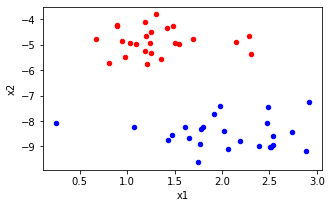

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


data = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=0.6)

df = pd.DataFrame({"x1": data[0][:,0], "x2": data[0][:,1], "y": data[1]})
fig, ax = plt.subplots(figsize=(5, 3))
for y, c in enumerate(["red", "blue"]):
    df[(df.y == y)].plot.scatter(x="x1", y="x2", color=c, ax=ax)

## 1.原始的な実装

In [7]:
import torch


dtype = torch.float
X = torch.from_numpy(data[0]).type(dtype)
Y = torch.from_numpy(data[1].reshape((-1, 1))).type(dtype)
print(X.shape)
print(Y.shape)

torch.Size([50, 2])
torch.Size([50, 1])


In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report


train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=42)
train_dataset = TensorDataset(train_x, train_y)
loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



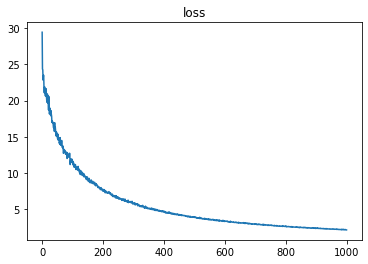

In [9]:
model = {
    "w": torch.randn((X.shape[1], 1), dtype=dtype, requires_grad=True),
    "b": torch.randn(1, dtype=dtype, requires_grad=True)
}

def forward(model, X):
    return (X @ model["w"] + model["b"]).sigmoid()

hyper_parameters = {
    "epoch": 1000,
    "eta": 1e-2
}

history = []
for t in range(hyper_parameters["epoch"]):
    loss_in_epoch = .0
    for x, y in loader:
        y_hat = forward(model, x)
        loss = - (y * y_hat + (1 - y) * (1 - y_hat)).log().sum()
        loss_in_epoch += loss.item()

        loss.backward()
        with torch.no_grad():
            model["w"] -= hyper_parameters["eta"] * model["w"].grad
            model["b"] -= hyper_parameters["eta"] * model["b"].grad
            model["w"].grad.zero_()
            model["b"].grad.zero_()

    history.append(loss_in_epoch)

pd.Series(history).plot.line(title="loss")
with torch.inference_mode():
    # Do not compute the gradient in inference_mode
    print(classification_report(test_y, (forward(model, test_x).numpy() > 0.5)))